In [1]:
import numpy as np
import os, sys, scipy
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import scikits.bootstrap as bootstrap  
from scipy.stats.stats import spearmanr, ttest_1samp, zscore, pearsonr
from scipy.ndimage.filters import gaussian_filter1d
from necessary_analysis_scripts import resampling_statistics,  run_stats_onetail, run_stats_twotail
from necessary_analysis_scripts import prettify_plot, calculate_aprime, load_data, load_data_cd

# Plotting defaults 

In [2]:
#plot within jupyter notebooks
%matplotlib inline 

#tab completion for files
%config IPCompleter.greedy=True 

#supress scientific notation
np.set_printoptions(suppress=True) 

#font defaults
plt.rcParams.update({'font.size': 14})
rc('text', usetex=False)
plt.rcParams['pdf.fonttype'] = 42
if os.path.isfile("/Library/Fonts/HelveticaNeue-Light.ttf"): 
    prop = fm.FontProperties(fname="/Library/Fonts/HelveticaNeue-Light.ttf",size=24)
else:
    prop = fm.FontProperties(size=24)

#color defaults
col_corr = [0/255.,98/255.,100/255.]
col_incorr = [218/255.,66/255.,36/255.]

# Load data

In [3]:
#project directory 
project_name = 'expt1a'

#load data 
subj_dat = load_data(project_name)

#basic project information
nsubj = len(subj_dat)
print("# of subjects:", nsubj)
nb = 4
nt = 800
nprobes = 160
ninfreq = 320
ncolors = 9
setsize = 6

# of subjects: 26


# Sustained attention performance

First, let's examine the performance in the sustained attention task

In this Sustained Attention to Response Task (or SART), participants respond to the shape of the items. However, we manipulate the probability of each shape: 90% of the items are circles and 10% of the items are squares. These imbalances make participants much more likely to make errors to the infrequent trials

Sensitivity (A'):	 0.87 	 0.06 s.d. 	95% CIs [0.85 0.89]

Accuracy:
Infrequent trials:	 55.18 	 18.16 s.d. 	95% CIs [48.52 62.42]
Frequent trials:	 97.14 	 2.42 s.d. 	95% CIs [96.   97.91]
Difference:		 41.96 	 17.74 s.d. 	95% CIs [34.96 48.68]


Parametric: ttest: t  11.83 p 4.92e-12
Nonparametric p < 0.001


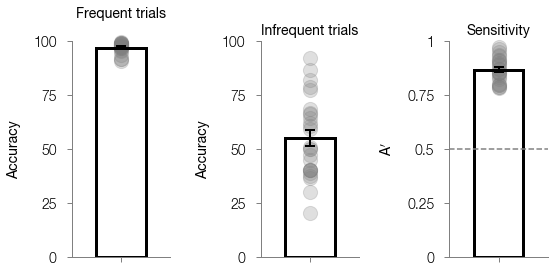

In [4]:
#calculate the accuracy in the sustained attention task
freq_acc, infreq_acc, aprime = np.zeros(nsubj), np.zeros(nsubj), np.zeros(nsubj)
for isubj in range(nsubj):
    acc = np.ravel(subj_dat[isubj].acc[:(nb*nt)]) #accuracy to all trials
    freq_trials = np.ravel(subj_dat[isubj].freq_trials[:(nb*nt)]) #locate frequent trials
    freq_acc[isubj] = np.mean(acc[freq_trials==1]==1) #calculate average frequent trial accuracy
    infreq_acc[isubj] = np.mean(acc[freq_trials==0]==1) #calculate average infrequent trial accuracy
    aprime[isubj] = calculate_aprime(freq_acc[isubj],1-infreq_acc[isubj]) #sensitivity

#convert to percentages
freq_acc = freq_acc*100
infreq_acc = infreq_acc*100

#compute the 95% confidence intervals (CIs)
freq_acc_CIs = bootstrap.ci(data=(freq_acc), statfunction=scipy.mean,n_samples=10000)
infreq_acc_CIs = bootstrap.ci(data=(infreq_acc), statfunction=scipy.mean,n_samples=10000)
freqinfreqdiff_acc_CIs = bootstrap.ci(data=(freq_acc-infreq_acc), statfunction=scipy.mean,n_samples=10000)
aprime_CIs = bootstrap.ci(data=(aprime), statfunction=scipy.mean,n_samples=10000)

#print the results (mean + CIs)
print("Sensitivity (A'):\t", np.round(np.mean(aprime),decimals=2), 
      "\t", np.round(np.std(aprime),decimals=2), "s.d.",
      "\t95% CIs", np.round(aprime_CIs,decimals=2))
print("\nAccuracy:")
print("Infrequent trials:\t", np.round(np.mean(infreq_acc),decimals=2), 
      "\t", np.round(np.std(infreq_acc),decimals=2), "s.d.",
      "\t95% CIs", np.round(infreq_acc_CIs,decimals=2))
print("Frequent trials:\t", np.round(np.mean(freq_acc),decimals=2), 
      "\t", np.round(np.std(freq_acc),decimals=2), "s.d.",
      "\t95% CIs", np.round(freq_acc_CIs,decimals=2))
print("Difference:\t\t", np.round(np.mean(freq_acc-infreq_acc),decimals=2), 
      "\t", np.round(np.std(freq_acc-infreq_acc),decimals=2), "s.d.",
      "\t95% CIs",  np.round(freqinfreqdiff_acc_CIs,decimals=2))
#run statistics on accurac
print("\n")
run_stats_onetail(freq_acc,infreq_acc)

def scatter_plot_data(ax,data,x=0):
    n = np.size(data)
    ax.scatter(np.ones(n)+x,data,s=200,facecolor='gray',alpha=.25,clip_on=False)#data points
    ax.bar(1,np.mean(data),.25,color='None',edgecolor='k',linewidth=3)
    ax.errorbar(1+x,np.mean(data),yerr=np.std(data)/np.sqrt(n),color='k',linewidth=2,capsize=5,capthick=2)#error bar
    
#Plot sustained attention data
fig, ax = plt.subplots(1,3,figsize=(8,4))

#Left plot: frequent trial error rate
scatter_plot_data(ax[0],freq_acc) 
prettify_plot(ax[0],ylim=[0,100],yt=([0,25,50,75,100]),ytl=([0,25,50,75,100]),yl="Accuracy",ylrot=90,
              xlim=(.75,1.25), xt=([1]),xtl=([""]),t='Frequent trials')

#Middle plot: infrequent trial error rate
scatter_plot_data(ax[1],infreq_acc)
prettify_plot(ax[1],ylim=[0,100],yt=([0,25,50,75,100]),ytl=([0,25,50,75,100]),yl="Accuracy",ylrot=90,
              xlim=(.75,1.25),xt=([1]),xtl=([""]),t='Infrequent trials')

#Right plot: sensitivity 
scatter_plot_data(ax[2],aprime)
ax[2].plot([.75,1.25],[.5,.5],'--',color='gray')
prettify_plot(ax[2],ylrot=90,xlim=(.75,1.25),ylim=[0,1],yt=([0,.25,.5,.75,1]),ytl=([0,.25,.5,.75,1]),yl="A$\'$",
                 xt=([1]),xtl=([""]),t='Sensitivity')

plt.show()

# Sustained attention performance decrements

Another key signature of sustained attention is that performance declines over blocks. We examine the average accuracy to infrequent trials for each block. Next we fit a line to relate block number (1–4) to accuracy, and examine whether the slope of that line is reliably negative. 

Infreq acc per block: [65. 57. 55. 53.]
Slope:  -3.99 [-5.88 -2.29]
Parametric: ttest: t  4.28 p 1.19e-04
Nonparametric p < 0.001


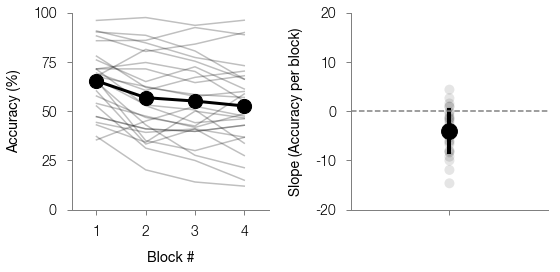

In [5]:
#preallocate
acc_m = np.zeros((nsubj,nb))
pfit_acc = np.zeros((nsubj,2))

#slope
for isubj in range(nsubj):
    for iblock in range(nb):
        itrials = iblock*nt+np.arange(nt)

        idx = (subj_dat[isubj].freq_trials[itrials]==0)
        acc_m[isubj,iblock] = np.nanmean(subj_dat[isubj].acc[itrials[idx]])*100

    pfit_acc[isubj] = np.polyfit(1+np.arange(4),acc_m[isubj],1)

#print summary statistics
pfit_acc_CI = bootstrap.ci(data=pfit_acc[:,0], statfunction=scipy.mean, n_samples=100000)
print("Infreq acc per block:", np.round(np.mean(acc_m,axis=0),decimals=0))
print("Slope: ", np.round(np.mean(pfit_acc[:,0]),decimals=2),np.round(pfit_acc_CI,decimals=2))
run_stats_onetail(-1*pfit_acc[:,0],0)

#figure
fig, ax = plt.subplots(1,2,figsize=(8,4))

#mean RT per block
ax[0].plot(1+np.arange(4),np.transpose(acc_m),color='k',alpha=.25)
ax[0].scatter(1+np.arange(4),np.mean(acc_m,axis=0),200,color='k')
ax[0].plot(1+np.arange(4),np.mean(acc_m,axis=0),color='k',linewidth=3)
prettify_plot(ax[0],ylrot=90,xlim=(.5,4.5),ylim=[0,100],yt=([0,25,50,75,100]),ytl=([0,25,50,75,100]),
              yl="Accuracy (%)",xt=([1,2,3,4]),xtl=([1,2,3,4]),xl='Block #')

#slope of linear fit
ax[1].scatter(np.zeros(nsubj),pfit_acc[:,0],100,color='k',alpha=.1,edgecolor='None')
ax[1].scatter(0,np.mean(pfit_acc[:,0]),250,color='k')
ax[1].errorbar(0,np.mean(pfit_acc[:,0]),yerr=np.std(pfit_acc[:,0]),color='k',linewidth=4)
ax[1].plot([-.5,.5],[0,0],'--',color='gray')
prettify_plot(ax[1],ylrot=90,xlim=(-.5,.5),ylim=[-20,20],yt=([-20,-10,0,10,20]),ytl=([-20,-10,0,10,20]),
              yl="Slope (Accuracy per block)",xt=([0]),xtl=([" "]))

plt.show()


# Working memory performance 

Now, let's examine the performance in the working memory portion of the task

In this whole report working memory task, participants respond to the color of the items. These memory probes are rare, only occuring 5% of the time. On each trial, participants have to select the color of all 6 items from the previous display

Working memory performance:	 3.09 [2.91 3.24]
Parametric: ttest: t  28.01 p 1.06e-20
Nonparametric p < 0.001


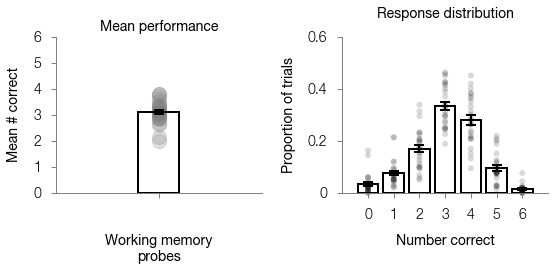

In [6]:
wm_n =np.zeros(nsubj) 
n_correct = np.arange(8)
bin_height_n = np.empty((nsubj,np.size(n_correct)-1))
wm_n_all = np.empty((nsubj,nprobes))

#calculate working memory performance
for isubj in range(nsubj):
    probe_trials = np.ravel(subj_dat[isubj].probe_trials[:(nb*nt)])==1 #working memory probes (boolean)
    wm_n_all[isubj] = subj_dat[isubj].wholereport_respacc_total[:(nb*nt)][probe_trials] #number correct for probes
    wm_n[isubj] = np.mean(wm_n_all[isubj]) #whole report trial accuracy
    a,_ = np.histogram(wm_n_all[isubj],n_correct,density=True)
    bin_height_n[isubj],_ = np.histogram(wm_n_all[isubj],n_correct,density=True) #histogram bin height
    

#Confidence intervals
wm_n_CIs = bootstrap.ci(data=wm_n, statfunction=scipy.mean,n_samples=100000) #confidence intervals
wm_chance = setsize/float(ncolors) #chance performance
print("Working memory performance:\t", np.round(np.mean(wm_n),decimals=2), np.round(wm_n_CIs,decimals=2))
run_stats_onetail(wm_n-0.67)#t, p = ttest_1samp(wm_n,0.67) #ttest
#print("Parametric: ttest: t ", np.round(t,decimals=2), "p", '{:0.2e}'.format(p/2), "Cohens dz: ", np.round(t/np.sqrt(nsubj),decimals=2)) #one-sided
    
#Plot distribution of whole report performance
fig, ax = plt.subplots(1,2,figsize=(8,4))

#Left plot: distribution 
ax[1].bar(n_correct[:-1],np.mean(bin_height_n,axis=0),color='None',edgecolor='k',linewidth=2)
ax[1].errorbar(n_correct[:-1],np.mean(bin_height_n,axis=0),yerr=np.std(bin_height_n,axis=0)/np.sqrt(float(nsubj)),
    linestyle='None',color='k',linewidth=2,capsize=5,capthick=2)
for ib in n_correct[:-1]:
    ax[1].scatter(np.zeros(nsubj)+ib,bin_height_n[:,ib],color='k',alpha=.15,linewidths=None,edgecolors='none',clip_on=False)
prettify_plot(ax[1],ylim=[0,.6],yt=([0,.2,.4,.6]),ytl=([0,.2,.4,.6]),yl='Proportion of trials',ylrot=90,
                    xlim=(-1,7),xt=([0,1,2,3,4,5,6]),xtl=([0,1,2,3,4,5,6]),xl='Number correct',
                    t='Response distribution')

#Right plot: average performance
ax[0].scatter(np.ones(nsubj),wm_n,s=200,facecolor='gray',alpha=.25,clip_on=False)
ax[0].bar(1,np.mean(wm_n),.1,color='None',edgecolor='k',linewidth=2)
ax[0].errorbar(1,np.mean(wm_n),yerr=np.std(wm_n)/np.sqrt(float(nsubj)),
    linestyle='None',color='k',linewidth=2,capsize=5,capthick=2)
prettify_plot(ax[0],ylim=[0,6],yt=([0,1,2,3,4,5,6]),ytl=([0,1,2,3,4,5,6]),yl='Mean # correct',ylrot=90,
              xlim=(.75,1.25),xt=([1]),xtl=' ',xl=("Working memory\nprobes"),t='Mean performance')
        
plt.show()


# Attention/memory relationship across individuals

Next, let's examine whether the performance of the attention and memory tasks is related across individuals. The critical measure of attention performance that we used is their average accuracy to the infrequent trials. We compare performance in 3 ways: 
1. Median split participants based on their attention performance, examine the mean WM performance of each group
2. Median split participants based on their attention performance, examine the distributions of WM performance of each group 
3. Correlate the attention performance of each individual with their mean WM performance

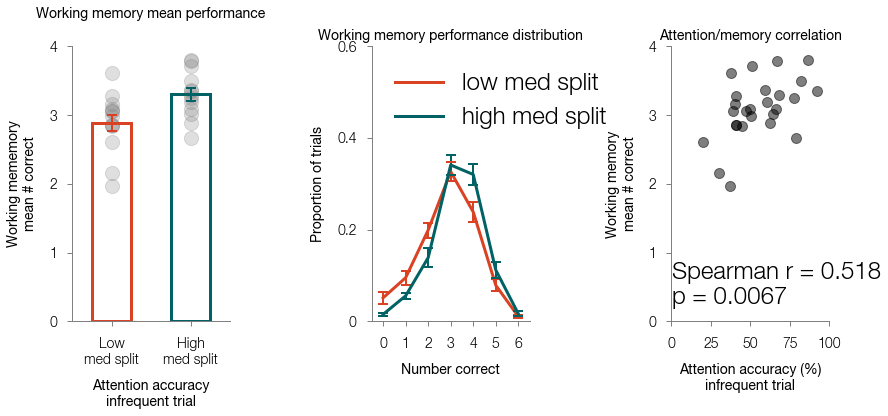

In [7]:
#first, median split the subjects based on sustained attention performance
subj_lowattn = np.where(infreq_acc<=np.median(infreq_acc))[0] #indices of lower performing subjects
subj_highattn = np.where(infreq_acc>np.median(infreq_acc))[0] #indices of higher performing subjects

#correlation
r,p_corr = spearmanr(infreq_acc,wm_n)

def scatter_plot_data(ax,data,x=0,c='k'):
    n = np.size(data)
    ax.scatter(np.ones(n)+x,data,s=200,facecolor='gray',alpha=.25,clip_on=False)#data points
    ax.bar(1+x,np.mean(data),.5,color='None',edgecolor=c,linewidth=3)#mean
    ax.errorbar(1+x,np.mean(data),yerr=np.std(data)/np.sqrt(n),color=c,linewidth=2,capsize=5,capthick=2)#error bar

def histplot_data(ax,bins,data,lab,col):
    ax.plot(bins,np.mean(data,axis=0),
            color=col,linewidth=3,label=lab)
    ax.errorbar(bins,np.mean(data,axis=0),
            yerr=np.std(data,axis=0)/np.sqrt(np.shape(data)[0]),
            linestyle='None',color=col,linewidth=2,capsize=5,capthick=2)
    
#make figure 
fig, ax = plt.subplots(1,3,figsize=(12,6))


#median split performance
scatter_plot_data(ax[0],wm_n[subj_lowattn],c=col_incorr)
scatter_plot_data(ax[0],wm_n[subj_highattn],x=1,c=col_corr)
prettify_plot(ax[0],ylrot=90,xlim=(.5,2.5),ylim=[0,4],t='Working memory mean performance',
         yt=([0,1,2,3,4]),ytl=([0,1,2,3,4]),yl='Working mememory\nmean # correct',
         xt=([1,2]),xtl=(["Low\nmed split","High\nmed split"]),xl='Attention accuracy\ninfrequent trial')

##working memory mean performance, median split median split groups
bins = np.arange(0,7)
hist_binprop = np.zeros((nsubj,7))
for isubj in range(nsubj):
    i = np.arange(0,np.max(np.ravel(wm_n_all[isubj]))+1,dtype=int)#.astype(int)
    b = np.bincount(np.ravel(wm_n_all[isubj]).astype(int))
    binprop = b/float(np.size(wm_n_all[isubj]))
    hist_binprop[isubj][i] = binprop
    
#working memory performance distribution, median split
histplot_data(ax[1],bins,hist_binprop[subj_lowattn],'low med split',col_incorr)
histplot_data(ax[1],bins,hist_binprop[subj_highattn],'high med split',col_corr)
ax[1].legend(frameon=False,prop=prop,loc='upper left',bbox_to_anchor=(0.01, .98))
prettify_plot(ax[1],ylrot=90,xlim=(-.5,6.5),ylim=[0,.6],t='Working memory performance distribution',
         yt=([0,.2,.4,.6]),ytl=([0,.2,.4,.6]),yl='Proportion of trials',
         xt=([0,1,2,3,4,5,6]),xtl=([0,1,2,3,4,5,6]),xl='Number correct')

#attention/memory correlation
ax[2].scatter(infreq_acc,wm_n,100,'k',alpha=.5)
prettify_plot(ax[2],ylrot=90,xlim=(0,100),ylim=[0,4],t='Attention/memory correlation',
         yt=([0,1,2,3,4]),ytl=([0,1,2,3,4]),yl="Working memory\nmean # correct",
         xt=([0,25,50,75,100]),xtl=([0,25,50,75,100]),xl='Attention accuracy (%)\ninfrequent trial')
ax[2].text(.35,.25,'Spearman r = ' + str(np.round(r,decimals=3)) + '\np = ' + str(np.round(p_corr,decimals=4)) ,fontsize=24,horizontalalignment='left',fontproperties=prop)

plt.show()


# Attention/memory relationship accross participants, part 2

Another signature of attention abilities is RT variance. Let's examine whether that relates to WM performance

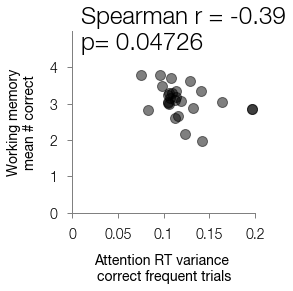

In [8]:
#calculate RT variance
rt_var = np.empty((nsubj,nb))
for isubj in range(nsubj):
    #calculate within block
    for iblock in range(nb): 
        #trial indices within that block
        itrials = iblock*nt+np.arange(800) 
        
        #indices of correct frequent trials
        idx = np.logical_and(subj_dat[isubj].freq_trials[itrials]==1,subj_dat[isubj].acc[itrials]==1)
        
        #rt variance for these trials
        rt_var[isubj,iblock] = np.std(subj_dat[isubj].rts[itrials[idx]]) 

#plot
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.scatter(np.mean(rt_var,axis=1),wm_n,100,'k',alpha=.5,clip_on=False)
prettify_plot(ax,ylrot=90,xlim=(0,.2),ylim=[0,5],
         yt=([0,1,2,3,4]),ytl=([0,1,2,3,4]),yl="Working memory\nmean # correct",
         xt=([0,.05,.1,.15,.2]),xtl=([0,.05,.1,.15,.2]),xl='Attention RT variance \ncorrect frequent trials')

#calculate correlation
r,p = spearmanr(np.mean(rt_var,axis=1),wm_n)
ax.text(.01,4.5,'Spearman r = ' + str(np.round(r,decimals=2)) + '\np= ' + str(np.round(p,decimals=5)),
       fontsize=16,ha='left',fontproperties=prop)

plt.show()

# Attention/memory relationship within individuals

Lastly, let's examine whether the performance of the attention and memory tasks is related within individuals. The critical measure of attention performance that we used is their average accuracy to the infrequent trials. 

1. We compare how WM performance is affected by whether they got the infrequent trial is correct. We observe that WM performance is worse following errors to the infrequent trial (i.e., attentional lapses). 

2. We compare how RTs leading up to an infrequent trial impact whether or not they were likely to get the infrequent trial correct. We observe that faster RTs precede errors to the infrequent trial (i.e., attentional lapses). 

/Users/megan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/Users/megan/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


0.4389423076923077
WM # inaccurate: 70.23 [58.88 80.27]
WM incorr: 2.868 [2.68 3.02]
WM corr: 3.214 [3.05 3.37]
Parametric: ttest: t  5.67 p 3.34e-06
Nonparametric p < 0.001
WM diff 0.3456855154265366 [0.24 0.48]
1.1337442383648382


RT incorr: 309 [292 332]
RT corr: 363 [348 382]
Parametric: ttest: t  8.59 p 3.16e-09
Nonparametric p < 0.001
RT diff: 54 [42 66]


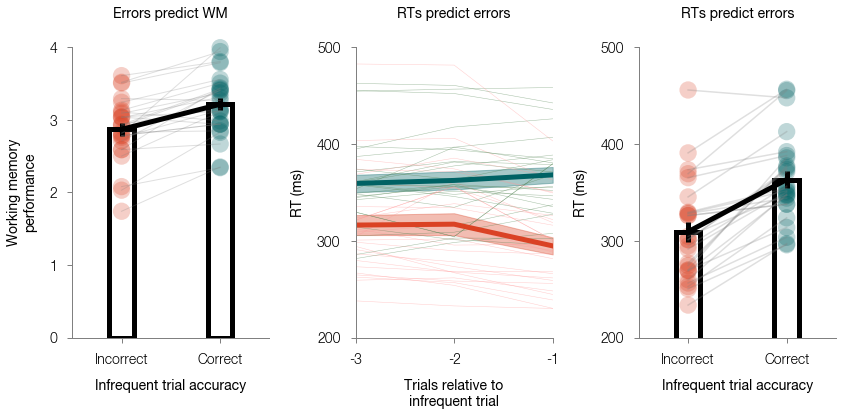

In [9]:
shifts = [-3,-2,-1] #trials pre-probe trial
nshifts = np.size(shifts)

rts_corr_m = np.zeros((nsubj,nshifts))
rts_incorr_m = np.zeros((nsubj,nshifts))
probe_inacc = np.zeros(nsubj)
wm_n_all = np.zeros((nsubj,nprobes))
wm_n_corr = np.empty(nsubj)
wm_n_incorr = np.empty(nsubj)
wm_n_diff = np.empty(nsubj)
nbins = 11
infreq_propacc_bin = np.empty((nsubj,nbins))
wm_n_bin = np.empty((nsubj,nbins))

for isubj in range(nsubj):

    #calculate whole report performance
    probe_trials = np.where(subj_dat[isubj].probe_trials[:(nb*nt)]==1)[0]
    wm_n_all[isubj,:nprobes] = subj_dat[isubj].wholereport_respacc_total[probe_trials]
    acc=subj_dat[isubj].acc[probe_trials]
    
    probe_inacc[isubj] = np.sum(acc!=1)
    
    wm_n_corr[isubj] = np.nanmean(np.ravel(wm_n_all[isubj,acc==1]))
    wm_n_incorr[isubj] = np.nanmean(np.ravel(wm_n_all[isubj,acc!=1]))
    wm_n_diff[isubj] = np.nanmean(wm_n_corr)-np.nanmean(wm_n_incorr)
    
    #index relevant trial locations
    infreq_trials = np.where(subj_dat[isubj].freq_trials[:(nb*nt)]==0)[0]
    infreq_acc = subj_dat[isubj].acc[infreq_trials]==1
    infreq_corr = np.where(subj_dat[isubj].acc[infreq_trials]==1)[0]
    infreq_incorr = np.where(subj_dat[isubj].acc[infreq_trials]!=1)[0]
    
    #reaction times
    rts = subj_dat[isubj].rts
    rts_shift = np.zeros((np.size(infreq_trials),nshifts)) #preallocate the shifted RTs
    rts_shift[:]= np.nan
    
    #shift rts relative to infrequent trial
    for i,ishift in enumerate(shifts):
         
        infreq_s = infreq_trials + ishift #infrequent trial indices, shifted back one 
        infreq_s = infreq_s[np.logical_and((infreq_s%nt)>=0,(infreq_s%nt)<nt)] #ensure doesn't span blocks
        
        #grab the RTs for the preceding trials
        rts_shift[np.logical_and((infreq_s%nt)>=0,(infreq_s%nt)<nt),i] = rts[infreq_s]
    
        rts_corr_m[isubj,i] = np.nanmean(rts_shift[infreq_corr,i]) #mean RT across trials pre and post correct response
        rts_incorr_m[isubj,i] = np.nanmean(rts_shift[infreq_incorr,i]) #mean RT across trials pre and post incorrect response

    rts_shift = np.nanmean(rts_shift,axis=1)
    infreq_acc = infreq_acc[~np.isnan(rts_shift)]
    temp_wm_n = subj_dat[isubj].wholereport_respacc_total[infreq_trials]
    temp_wm_n = temp_wm_n[~np.isnan(rts_shift)]
    rts_shift = rts_shift[~np.isnan(rts_shift)]
    
    perc_bins = np.linspace(0,100,nbins+1,endpoint=True)[1:]
    rt_bins = np.percentile(rts_shift,perc_bins)
    
    for ibin in range(nbins):
        if ibin==0:
            infreq_propacc_bin[isubj,0] = np.nanmean(infreq_acc[rts_shift<rt_bins[0]])*100
        elif ibin==(nbins-1):
            infreq_propacc_bin[isubj,ibin] = np.nanmean(infreq_acc[rts_shift>rt_bins[-2]])*100
        else:
            infreq_propacc_bin[isubj,ibin] = np.nanmean(infreq_acc[np.logical_and(rts_shift>rt_bins[ibin-1],rts_shift<rt_bins[ibin])])*100

print(np.mean(probe_inacc/np.size(probe_trials)))
#Print 95% confidence intervals for whole report accuracy
CIs = bootstrap.ci(data=(probe_inacc[probe_inacc!=0]), statfunction=scipy.mean,n_samples=10000)
print("WM # inaccurate:", np.round(np.mean(probe_inacc[probe_inacc!=0]),decimals=2), np.round(CIs,decimals=2))
CIs = bootstrap.ci(data=(wm_n_incorr[~np.isnan(wm_n_incorr)]), statfunction=scipy.mean,n_samples=10000)
print("WM incorr:", np.round(np.mean(wm_n_incorr[~np.isnan(wm_n_incorr)]),decimals=3), np.round(CIs,decimals=2))
CIs = bootstrap.ci(data=(wm_n_corr[~np.isnan(wm_n_incorr)]), statfunction=scipy.mean,n_samples=10000)
print("WM corr:", np.round(np.mean(wm_n_corr[~np.isnan(wm_n_incorr)]),decimals=3),np.round(CIs,decimals=2))
run_stats_onetail(wm_n_corr[~np.isnan(wm_n_incorr)],wm_n_incorr[~np.isnan(wm_n_incorr)])
CIs = bootstrap.ci(data=(wm_n_corr[~np.isnan(wm_n_incorr)]-wm_n_incorr[~np.isnan(wm_n_incorr)]), statfunction=scipy.mean,n_samples=10000)
print("WM diff", np.mean(wm_n_corr[~np.isnan(wm_n_incorr)])-np.mean(wm_n_incorr[~np.isnan(wm_n_incorr)]),np.round(CIs,decimals=2))
d_z = np.mean(wm_n_corr[~np.isnan(wm_n_incorr)]-wm_n_incorr[~np.isnan(wm_n_incorr)])/np.std(wm_n_corr[~np.isnan(wm_n_incorr)]-wm_n_incorr[~np.isnan(wm_n_incorr)])
print(d_z)

print("\n")
CIs = bootstrap.ci(data=(rts_incorr_m*1000), statfunction=scipy.mean,n_samples=100000)
print("RT incorr:", int(np.round(np.mean(rts_incorr_m*1000),decimals=0)), (np.round(CIs,decimals=0)).astype(int))
CIs = bootstrap.ci(data=(rts_corr_m*1000), statfunction=scipy.mean,n_samples=100000)
print("RT corr:", int(np.round(np.mean(rts_corr_m*1000),decimals=0)), (np.round(CIs,decimals=0)).astype(int))
run_stats_onetail(np.mean(rts_corr_m,axis=1)*1000,np.mean(rts_incorr_m,axis=1)*1000)
CIs = bootstrap.ci(data=(rts_corr_m*1000-rts_incorr_m*1000), statfunction=scipy.mean,n_samples=100000)
print("RT diff:",int(np.round(np.mean(rts_corr_m)*1000-np.mean(rts_incorr_m)*1000)),(np.round(CIs,decimals=0)).astype(int))
    
#MAKE FIGURE
fig = plt.figure(figsize=(12,6))

#plot whole report performance
ax = plt.subplot(131)
for isubj in range(nsubj):
    if ~np.isnan(wm_n_incorr[isubj]):
        ax.plot([0,1],[wm_n_incorr[isubj],wm_n_corr[isubj]],linewidth=1,color='gray',alpha=.25)
ax.scatter(np.zeros(np.sum(~np.isnan(wm_n_incorr))),wm_n_incorr[~np.isnan(wm_n_incorr)],
           s=300,facecolors=col_incorr,alpha=.25,clip_on=False,edgecolors='none') #correct probe trials
ax.scatter(np.ones(np.sum(~np.isnan(wm_n_incorr))),wm_n_corr[~np.isnan(wm_n_incorr)],
           s=300,facecolors=col_corr,alpha=.25,clip_on=False,edgecolors='none') #incorrect probe trials
ax.bar(0,np.mean(wm_n_incorr[~np.isnan(wm_n_incorr)]),.25,color='None',edgecolor='k',linewidth=5)
ax.bar(1,np.mean(wm_n_corr[~np.isnan(wm_n_incorr)]),.25,color='None',edgecolor='k',linewidth=5)
ax.errorbar(0,np.mean(wm_n_incorr[~np.isnan(wm_n_incorr)]),
            yerr=np.std(wm_n_incorr[~np.isnan(wm_n_incorr)])/np.sqrt(np.sum(~np.isnan(wm_n_incorr))),
            color='k',linewidth=5)
ax.errorbar(1,np.mean(wm_n_corr[~np.isnan(wm_n_incorr)]),
            yerr=np.std(wm_n_corr[~np.isnan(wm_n_incorr)])/np.sqrt(np.sum(~np.isnan(wm_n_incorr))),
            color='k',linewidth=5)
ax.plot([0,1],[np.mean(wm_n_incorr[~np.isnan(wm_n_incorr)]),np.mean(wm_n_corr[~np.isnan(wm_n_incorr)])],color='k',linewidth=5)

prettify_plot(ax,ylim=([0,4]), yt=([0,1,2,3,4,5,6]),ytl=([0,1,2,3,4,5,6]),yl='Working memory\nperformance',ylrot=90,
              xlim=(-.5,1.5), xt=([0,1]),xtl=(['Incorrect','Correct']),xl='Infrequent trial accuracy',
              t='Errors predict WM')

#plot sustained attention performance
ax = plt.subplot(132)
for isubj in range(nsubj):
    ax.plot(shifts,rts_corr_m[isubj]*1000,color=[.3,.5,.3],alpha=.5,linewidth=.5)#correct trials
    ax.plot(shifts,rts_incorr_m[isubj]*1000,color=[1,.6,.6],alpha=.5,linewidth=.5)#incorrect trials
    
#plot averages
ax.fill_between(shifts,np.mean(rts_corr_m*1000,axis=0)-np.std(rts_corr_m*1000,axis=0)/np.sqrt(nsubj),
                np.mean(rts_corr_m,axis=0)*1000+np.std(rts_corr_m*1000,axis=0)/np.sqrt(nsubj),
                alpha=.35,color=col_corr,edgecolor='None')#correct trials
ax.fill_between(shifts,np.mean(rts_incorr_m*1000,axis=0)-np.std(rts_incorr_m*1000,axis=0)/np.sqrt(nsubj),
                np.mean(rts_incorr_m,axis=0)*1000+np.std(rts_incorr_m*1000,axis=0)/np.sqrt(nsubj),
                alpha=.35,color=col_incorr,edgecolor='None')#incorrect trials
ax.plot(shifts,np.mean(rts_corr_m,axis=0)*1000,color=col_corr,linewidth=5)#incorrect trials
ax.plot(shifts,np.mean(rts_incorr_m,axis=0)*1000,color=col_incorr,linewidth=5)#incorrect trials
prettify_plot(ax,ylim=([200,500]),yt=([200,300,400,500]),ytl=([200,300,400,500]),yl='RT (ms)',ylrot=90,
              xlim=(-3,-1),xl='Trials relative to\ninfrequent trial', xt=([-3,-2,-1]),xtl=([-3,-2,-1]),
              t='RTs predict errors')

#plot average pre-trial sustained attention performance
ax = plt.subplot(133)
ax.scatter(np.zeros(nsubj),np.mean(rts_incorr_m,axis=1)*1000,s=300,color=col_incorr,edgecolor='None',alpha=.25)#incorrect trials
ax.scatter(np.ones(nsubj),np.mean(rts_corr_m,axis=1)*1000,s=300,color=col_corr,edgecolor='None',alpha=.25)#correct trials
ax.plot([0,1],[np.mean(rts_incorr_m,axis=1)*1000,np.mean(rts_corr_m,axis=1)*1000],color='gray',alpha=.25)
ax.bar(0,np.mean(rts_incorr_m)*1000,.25,color='None',edgecolor='k',linewidth=5)#correct trials
ax.bar(1,np.mean(rts_corr_m)*1000,.25,color='None',edgecolor='k',linewidth=5)#incorrect trials
ax.errorbar(0,np.mean(rts_incorr_m)*1000,yerr=np.std(rts_incorr_m)*1000/np.sqrt(nsubj),color='k',linewidth=5)
ax.errorbar(1,np.mean(rts_corr_m)*1000,yerr=np.std(rts_corr_m)*1000/np.sqrt(nsubj),color='k',linewidth=5)
ax.plot([0,1],[np.mean(rts_incorr_m)*1000,np.mean(rts_corr_m)*1000],color='k',linewidth=5)#incorrect trials
prettify_plot(ax,ylim=([200,500]),yt=([200,300,400,500]),ytl=([200,300,400,500]),yl='RT (ms)',ylrot=90,
              xlim=(-.5,1.5),xt=([0,1]),xtl=(['Incorrect','Correct']),xl='Infrequent trial accuracy',
              t='RTs predict errors')

plt.show()

# Binning analysis, based on preceding RT

Rather than splitting based on accuracy, now split based on preceding (trailing RT)

For each participant, sort based on preceding RT and spllit the data into various number of bins

Then, calculate for each bin, calculate the average accuracy to the infrequent trials.

For each participant, fit a line to the slope of the attention accuracy across bins. 

Across participants, evaluate whether that line is reliably positive. 

/Users/megan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


slope: 4.36 [3.488 5.146]
yint: 31.52 [22.484 41.896]
Parametric: ttest: t  10.12 p 1.25e-10
Nonparametric p < 0.001


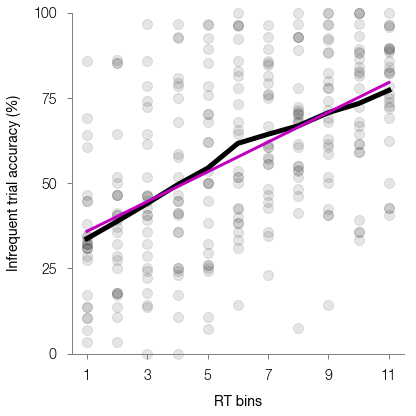

In [10]:
shifts = [-3,-2,-1] #trials pre-probe trial
nshifts = np.size(shifts)

rts_corr_m = np.zeros((nsubj,nshifts))
rts_incorr_m = np.zeros((nsubj,nshifts))
probe_inacc = np.zeros(nsubj)
nbins = 11
infreq_propacc_bin = np.empty((nsubj,nbins))

for isubj in range(nsubj):

    #calculate whole report performance
    infreq_trials = np.where(subj_dat[isubj].freq_trials[:(nb*nt)]==0)[0]
    infreq_acc=subj_dat[isubj].acc[infreq_trials]

    #reaction times
    rts = subj_dat[isubj].rts
    rts_shift = np.zeros((np.size(infreq_trials),nshifts)) #preallocate the shifted RTs
    rts_shift[:]= np.nan

    #shift rts relative to infrequent trial
    for i,ishift in enumerate(shifts):
        infreq_s = infreq_trials+ishift
        
        rts_shift[np.logical_and((infreq_s%nt)>=0,(infreq_s%nt)<nt),i] = rts[infreq_s]
    
    rts_shift = np.nanmean(rts_shift,axis=1)
    infreq_acc = infreq_acc[~np.isnan(rts_shift)]
    rts_shift = rts_shift[~np.isnan(rts_shift)]
    
    perc_bins = np.linspace(0,100,nbins+1,endpoint=True)[1:]
    
    rt_bins = np.percentile(rts_shift,perc_bins)
    
    for ibin in range(nbins):
        if ibin==0:
            infreq_propacc_bin[isubj,0] = np.nanmean(infreq_acc[rts_shift<rt_bins[0]])*100
        elif ibin==(nbins-1):
            infreq_propacc_bin[isubj,ibin] = np.nanmean(infreq_acc[rts_shift>rt_bins[-2]])*100
        else:
            infreq_propacc_bin[isubj,ibin] = np.nanmean(infreq_acc[np.logical_and(rts_shift>rt_bins[ibin-1],rts_shift<rt_bins[ibin])])*100

#test linear slope is positive
pfit = np.empty((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(1+np.arange(nbins),infreq_propacc_bin[isubj],1)

CIs_0 = bootstrap.ci(data=(pfit[:,0]), statfunction=scipy.mean,n_samples=1000000)
print("slope:", np.round(np.mean(pfit[:,0],axis=0),decimals=2),np.round(CIs_0,decimals=3))
CIs_1 = bootstrap.ci(data=(pfit[:,1]), statfunction=scipy.mean,n_samples=1000000)
print("yint:",np.round(np.mean(pfit[:,1],axis=0),decimals=2),np.round(CIs_1,decimals=3))

run_stats_onetail(pfit[:,0])

#plot
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for isubj in range(nsubj):
    ax.scatter(1+np.arange(nbins),infreq_propacc_bin[isubj],s=100,color='black',alpha=.1,clip_on=False)
ax.plot(1+np.arange(nbins),np.nanmean(infreq_propacc_bin,axis=0),color='k',linewidth=5)
ax.plot([1,11],[np.mean(pfit[:,1])+1*np.mean(pfit[:,0]),np.mean(pfit[:,1])+11*np.mean(pfit[:,0])],'m',linewidth=3)
prettify_plot(ax,ylim=([0,100]),yt=([0,25,50,75,100]),ytl=([0,25,50,75,100]),yl='Infrequent trial accuracy (%)',ylrot=90,
              xlim=(.5,nbins+.5),xt=(np.arange(0,nbins,2)+1),xtl=(np.arange(0,nbins,2)+1),xl='RT bins')


# Does RT relate to WM?

Among the correct probed trials, does the preceding RT correlate with WM performance (number of items correct) 

In [11]:
shifts = [-2,-1,0]
nshifts = np.size(shifts)
wm_m = np.empty((nsubj,nprobes))
r_corrRTwithm = np.empty((nsubj))
all_rts = []
all_wm_m = []
ntrials_eligible = np.zeros((nsubj),dtype=int)

for isubj in range(nsubj):

    #calculate working memory performance
    probe_trials = np.where(subj_dat[isubj].probe_trials[:(nb*nt)]==1)[0]
    probe_trials_acc=subj_dat[isubj].acc[probe_trials]  
    wm_m[isubj,:nprobes] = subj_dat[isubj].wholereport_respacc_total[probe_trials]
    
    #reaction times
    rts = subj_dat[isubj].rts
    rts_shift = np.zeros((np.size(probe_trials),nshifts)) #preallocate the shifted RTs
    rts_shift[:]= np.nan
    
    #shift rts relative to infrequent trial
    for i,iprobe in enumerate(probe_trials):
        if (iprobe%nt)>2:
            itrials = iprobe//nt*nt+np.arange(nt)
            rts_m = np.mean(rts[itrials])
            
            preceding_trials = iprobe+shifts
            rts_shift[i] = rts[preceding_trials]-rts_m 
    
    rt_mean = np.mean(rts_shift,axis=1)
    i = np.where(np.logical_and(np.isnan(rt_mean)==0,probe_trials_acc==1))[0]
    
    r_corrRTwithm[isubj],_ = spearmanr(rt_mean[i],wm_m[isubj,i])

CIs = bootstrap.ci(data=(r_corrRTwithm), statfunction=scipy.mean,n_samples=100000)
print("Correlation:\t", np.round(np.mean(r_corrRTwithm),decimals=3), "\t95% CIs", np.round(CIs,decimals=3))

#fisher z transform
z = .5*np.log((1+r_corrRTwithm)/(1-r_corrRTwithm))

#run statistics
p=run_stats_onetail(z)

Correlation:	 0.012 	95% CIs [-0.032  0.055]
Parametric: ttest: t  0.52 p 3.05e-01
Nonparametric p: = 0.302
